In [1]:
import os
import random
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Data preparation

In [2]:
data = pd.read_csv(r'C:\Users\B.R\Documents\HvA\Master_DDB\MP\Scraper_eWOM\eWOM\spiders\metacritic.csv')
data.columns

Index(['Game', 'Metascore', 'UserScore', 'Publisher', 'ReleaseDate', 'Genre',
       'NumberOfOnlinePlayers', 'Cast', 'Credits', 'CriticsReviews',
       'UserReviews'],
      dtype='object')

In [3]:
#making an array with all online multiplayer elements
array = ['OnlineMultiplayer', 'MassivelyMultiplayerOnlineMultiplayer', 'OnlineMultiplayerUpto8Players','2PlayersOnlineMultiplayer', 'OnlineMultiplayerUpto4Players', 'Role-Playing,MassivelyMultiplayerOnline,Fantasy,Action,General,General', 'BroadbandOnlyOnlineSystemLink', 'LiveAwareOnlineSystemLink', 'BroadbandOnlyOnline', 'Online', 'Role-Playing,MassivelyMultiplayerOnline,Fantasy', 'Role-Playing,MassivelyMultiplayerOnline,MassivelyMultiplayer,Fantasy', 'OnlineMultiplayerUpto16Players', 'OnlineMultiplayerUpto18Players', 'BroadbandOnlyLiveAwareOnline', 'Role-PlayingMassivelyMultiplayerOnline,MassivelyMultiplayer,Fantasy,Fantasy', 'Role-Playing,ActionAdventure,Fantasy,MassivelyMultiplayerOnline,General,Fantasy,Fantasy', 'Role-Playing,MassivelyMultiplayerOnline,ActionRPG,MassivelyMultiplayer,Fantasy,Fantasy', 'MassivelyMultiplayerOnline,Role-Playing,Sci-Fi,Action,Shooter,Shooter,Third-Person,Sci-Fi,Sci-Fi,Arcade', 'OnlineMultiplayerUpto22Players', 'OnlineMultiplayerUpto30Players', 'OnlineMultiplayerUpto60Players'
'OnlineMultiplayerUpto6Players', 'Fantasy,Role-Playing,MassivelyMultiplayerOnline,MassivelyMultiplayer,Fantasy', 'OnlineMultiplayerUpto3Players', 'OnlineMultiplayerUpto64Players', 'OnlineMultiplayerUpto10Players', 'Role-Playing,MassivelyMultiplayerOnline,MassivelyMultiplayer,Sci-Fi,Sci-Fi', 'OnlineMultiplayerUpto32Players']

#selecting all rows with array elements
data = data.loc[data['NumberOfOnlinePlayers'].isin(array)]

In [4]:
#Loading sentiment scores
innovativenesscores = pd.read_csv(r'C:\Users\B.R\Documents\HvA\Master_DDB\MP\analysis\multiplayer_model\mp_innovativeness_analysis\mp_innovativeness_score_userreviews.csv')
innovativenesscores.head()

,Game,Total_innovativeness,StdDev_innovativeness
0,20XX,0,0.000000
1,9th Dawn III: Shadow of Erthil,2,0.165521
2,AFL Evolution 2,0,0.000000
3,AO International Tennis,0,0.000000
4,AO Tennis 2,0,0.000000


In [5]:
#Loading sales_data
sales_data = pd.read_csv(r'C:\Users\B.R\Documents\HvA\Master_DDB\MP\Scraper_eWOM\eWOM\spiders\vgchartz.csv')
sales_data.head()

,Game,Platform,Publisher,VGChartzScore,CriticScore,TotalSales,ReleaseDate,LastUpdate
0,Grand Theft Auto: Liberty City Stories,PSP,Rockstar Games,N/A,8.8,7.72m,25th Oct 05,NaN
1,Grand Theft Auto: Vice City Stories,PSP,Rockstar Games,N/A,8.4,5.08m,31st Oct 06,NaN
2,Monster Hunter Freedom 3,PSP,Capcom,N/A,N/A,4.87m,01st Dec 10,08th Jan 19
3,Gran Turismo,PSP,Sony Computer Entertainment,7.5,7.7,2.93m,01st Oct 09,NaN
4,Monster Hunter Freedom Unite,PSP,Capcom,N/A,7.7,5.50m,23rd Jun 09,NaN


In [6]:
#merging sentiment and sales data
innosales = pd.merge(innovativenesscores, sales_data, on='Game', how='left')
innosales.head()

,Game,Total_innovativeness,StdDev_innovativeness,Platform,Publisher,VGChartzScore,CriticScore,TotalSales,ReleaseDate,LastUpdate
0,20XX,0,0.000000,NS,Batterystaple Games,N/A,N/A,NaN,10th Jul 18,09th Mar 20
1,9th Dawn III: Shadow of Erthil,2,0.165521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFL Evolution 2,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AO International Tennis,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AO Tennis 2,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Loading metascores 
metacritic = data
metacritic.head()

,Game,Metascore,UserScore,Publisher,ReleaseDate,Genre,NumberOfOnlinePlayers,Cast,Credits,CriticsReviews,UserReviews
140,Timespinner,84.0,7.3,Chucklefish,"Jun 4, 2019","Action,Platformer,2D",OnlineMultiplayer,NaN,NaN,"[{'CriticName': 'NF Magazine', 'CriticScore': ...","[{'UserName': None, 'UserReviewScore': '90', '..."
224,Gyro Boss DX,NaN,NaN,Chequered Ink Ltd.,"May 3, 2019","Action,Shooter,Shoot-'Em-Up,Top-Down",OnlineMultiplayer,NaN,NaN,NaN,NaN
225,Black Paradox,NaN,7.2,Digerati Distribution,"May 3, 2019","Action,Shooter,Shoot-'Em-Up,Horizontal",OnlineMultiplayer,NaN,NaN,"[{'CriticName': None, 'CriticScore': '75', 'Cr...","[{'UserName': None, 'UserReviewScore': '65', '..."
255,Redout,70.0,7.2,Nicalis,"May 14, 2019","Racing,Arcade,Futuristic",OnlineMultiplayer,NaN,NaN,"[{'CriticName': None, 'CriticScore': '76', 'Cr...","[{'UserName': None, 'UserReviewScore': '70', '..."
308,Happy Words,NaN,NaN,LAN - GAMES EOOD,"May 29, 2019","Puzzle,Logic",OnlineMultiplayer,NaN,NaN,"[{'CriticName': None, 'CriticScore': '20', 'Cr...","[{'UserName': None, 'UserReviewScore': '20', '..."


In [8]:
finaldata = pd.merge(innosales, metacritic, on='Game', how='left')
finaldata.head()

,Game,Total_innovativeness,StdDev_innovativeness,Platform,Publisher_x,VGChartzScore,CriticScore,TotalSales,ReleaseDate_x,LastUpdate,Metascore,UserScore,Publisher_y,ReleaseDate_y,Genre,NumberOfOnlinePlayers,Cast,Credits,CriticsReviews,UserReviews
0,20XX,0,0.000000,NS,Batterystaple Games,N/A,N/A,NaN,10th Jul 18,09th Mar 20,77.0,NaN,Fire Hose Games,"Jul 10, 2018","Action,Platformer,2D",2PlayersOnlineMultiplayer,NaN,NaN,"[{'CriticName': None, 'CriticScore': '90', 'Cr...","[{'UserName': None, 'UserReviewScore': '80', '..."
1,20XX,0,0.000000,NS,Batterystaple Games,N/A,N/A,NaN,10th Jul 18,09th Mar 20,77.0,7.1,Fire Hose Games,"Jul 10, 2018","Action,Platformer,2D",2PlayersOnlineMultiplayer,NaN,NaN,"[{'CriticName': None, 'CriticScore': '90', 'Cr...","[{'UserName': None, 'UserReviewScore': '60', '..."
2,9th Dawn III: Shadow of Erthil,2,0.165521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Valorware,"Oct 6, 2020","Role-Playing,ActionRPG",OnlineMultiplayer,NaN,NaN,"[{'CriticName': None, 'CriticScore': '70', 'Cr...","[{'UserName': None, 'UserReviewScore': '70', '..."
3,9th Dawn III: Shadow of Erthil,2,0.165521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Valorware,"Oct 6, 2020","Role-Playing,ActionRPG",OnlineMultiplayer,NaN,NaN,"[{'CriticName': None, 'CriticScore': '78', 'Cr...","[{'UserName': None, 'UserReviewScore': '60', '..."
4,AFL Evolution 2,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tru Blu,"Apr 16, 2020","Sports,Team,Football,Arcade",OnlineMultiplayer,NaN,NaN,NaN,NaN


In [9]:
finaldata.dropna(subset = ['Total_innovativeness', 'UserScore', 'TotalSales'], inplace=True)

In [10]:
#Remove Letter M from sales data
finaldata['TotalSales'] = finaldata['TotalSales'].map(lambda x: x.rstrip('m'))

In [11]:
#validation on null data and NaNs in dataset
print(finaldata[['Total_innovativeness', 'UserScore', 'TotalSales']].isnull().sum())
print(finaldata[['Total_innovativeness', 'UserScore', 'TotalSales']].isna().sum())

Total_innovativeness    0
UserScore               0
TotalSales              0
dtype: int64
Total_innovativeness    0
UserScore               0
TotalSales              0
dtype: int64


# Multivariate regression


In [12]:
#define X and Y dependent and independent variables
X = finaldata[['Total_innovativeness', 'UserScore']].astype(float)
y = finaldata['TotalSales'].astype(float)

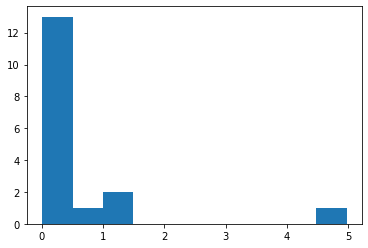

In [13]:
#check distribution of the data
plt.hist(y, bins=10)
plt.show()

In [14]:
#apply data tranformation with log transformation
y = np.log(y+1)

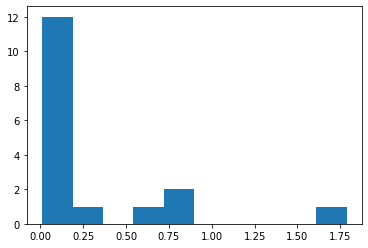

In [15]:
#check distribution of data again
plt.hist(y, bins=10)
plt.show()

In [16]:
#adding a constant (Y-intercept)
X = sm.add_constant(X)

In [17]:
#define model
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

In [18]:
#print regression results
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             TotalSales   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.056
Method:                 Least Squares   F-statistic:                    0.1574
Date:                Fri, 11 Jun 2021   Prob (F-statistic):              0.697
Time:                        17:15:40   Log-Likelihood:                -10.483
No. Observations:                  17   AIC:                             24.97
Df Residuals:                      15   BIC:                             26.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6017 